In [2]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Simulate Data

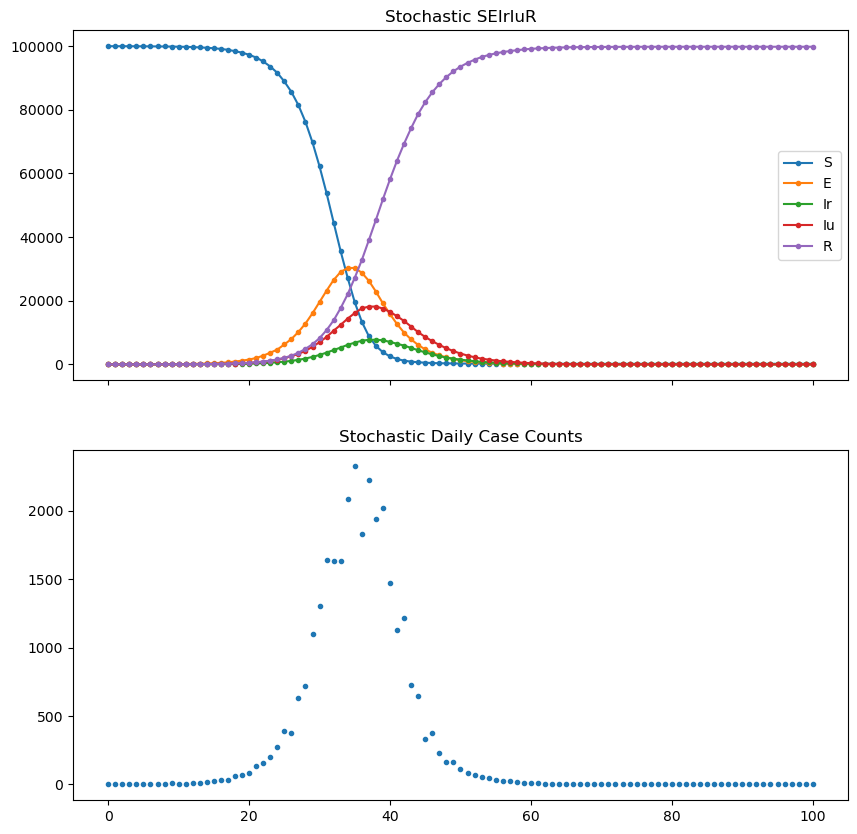

In [3]:
import importlib
import sys
import os

import seir
importlib.reload(seir)

true_params = {
    'beta': 2.1,
    'mu': 0.5,
    'Z': 4,
    'D': 4.,
    'alpha': 0.3,
    'n_t': 100,
    'N': 100_000.,
    'E0': 0.,
    'Iu0': 10.,
}

np.random.seed(1994)
data = seir.simualte_data(**true_params, add_noise=True, noise_param=1/50)
data.plot_all()

## CRAZY MODEL THAT IS WEIRD (Ignore for now)

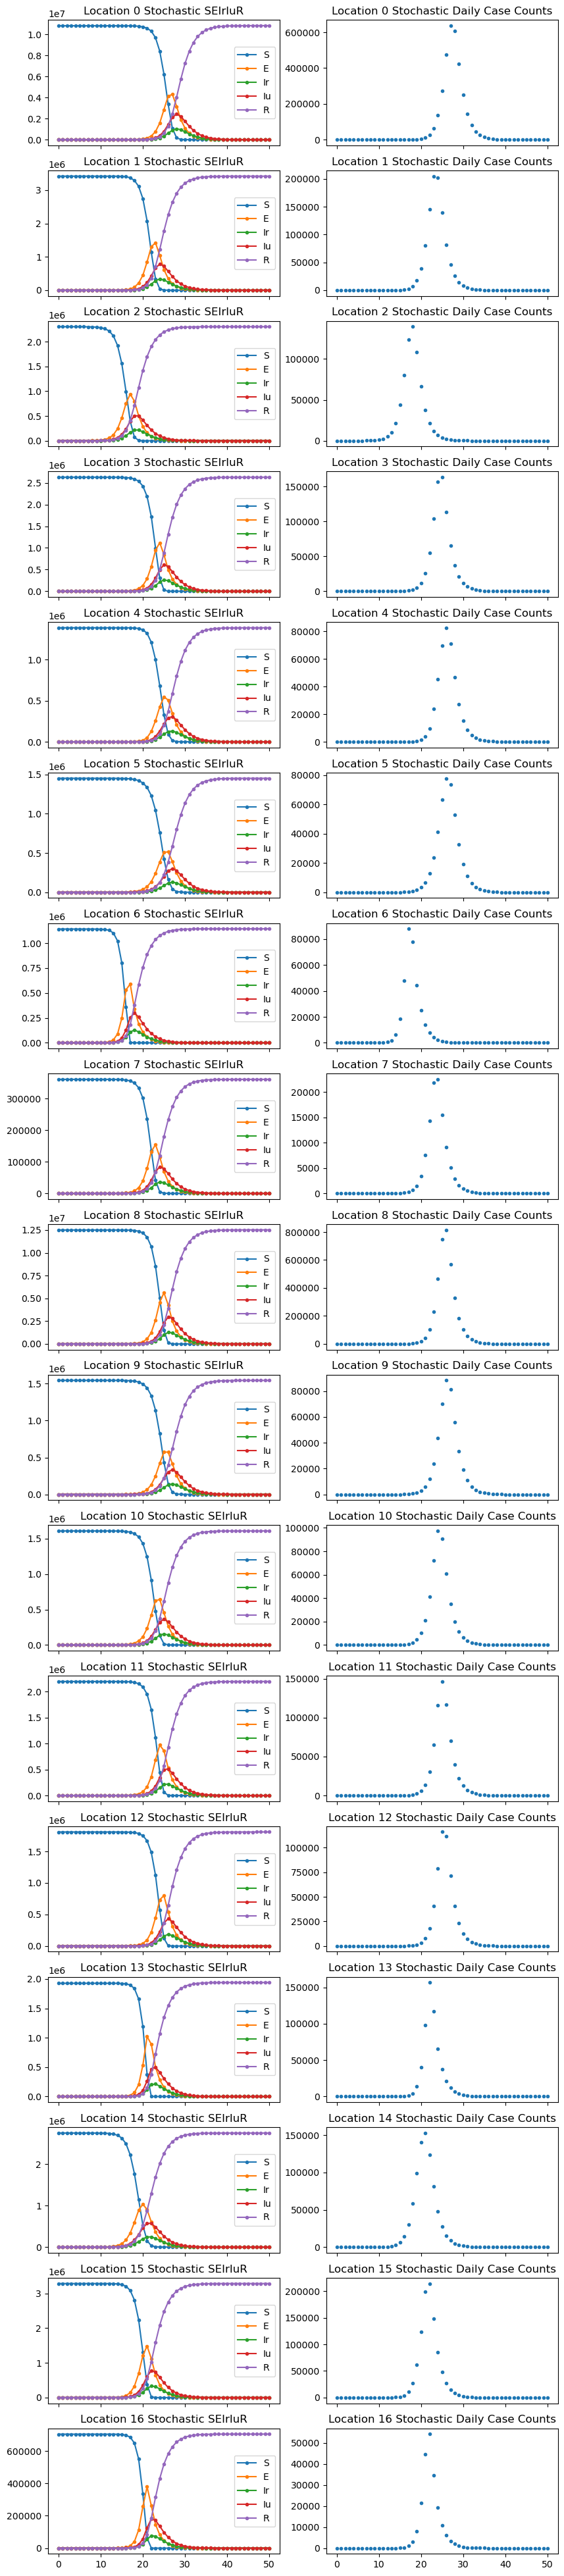

In [46]:
import seir_metapop
importlib.reload(seir_metapop)

N = np.loadtxt("N.csv", delimiter=",", dtype=str).astype(np.float64)

true_params = {
    'beta': None,
    'mu': 0.5,
    'Z': 4,
    'D': 4.,
    'alpha': 0.3,
    'n_t': 50,
    'n_loc': 17,
    'N': N,
    'E0': 0.,
    'Iu0': 10.,
}

np.random.seed(1994)
data = seir_metapop.simualte_data(**true_params, add_noise=True, noise_param=1/50)
data.plot_all()

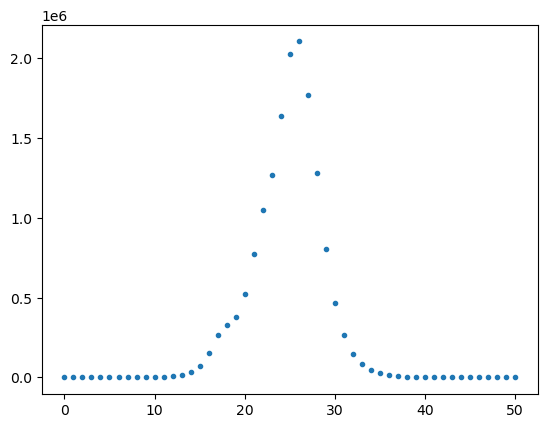

In [50]:
plt.plot(np.sum(data.i, axis=1), '.')

# Archive

In [ ]:
#  def f(t, x, θ, N, dt=1, noise_param=1/25):
#     """
#     forecast step
#     S = x[0]
#     E = x[1]
#     Ir = x[2]
#     Iu = x[3]
#     R = x[4]
#     """

#     # Stochastic transitions
#     dSE = np.random.poisson(true_params["beta"]*S[t]*(Ir[t]+self.mu*Iu[t])/self.N)
#     dEI = np.random.poisson(E[t]/self.Z)
#     dIrR = np.random.poisson(Ir[t]/self.D)
#     dIuR = np.random.poisson(Iu[t]/self.D)

#     S_new = np.clip(S[t]-dSE, 0, self.N)
#     E_new = np.clip(E[t]+dSE-dEI, 0, self.N)
#     Ir_new = np.clip(Ir[t]+dEI*self.alpha-dIrR, 0, self.N)
#     Iu_new = np.clip(Iu[t]+dEI*(1-self.alpha)-dIuR, 0, self.N)
#     R_new = np.clip(R[t]+dIrR+dIuR, 0, self.N)
    
#     x_new = np.concatenate((S_new, E_new, Ir_new, Iu_new, R_new, dEI*self.alpha))

#     return x_new

# def h(x):
#     """
#     Observational function.
#         Args:
#             x: state space
#     """
#     return x[-1]

# def f0(N, m=300):
#     """
#     Initial guess of the state space.
#         Args:
#             N: population
#             m: number of ensemble members
#     """

#     S0 = np.random.uniform(N*0.8, pop, size=m)
#     E0 = np.zeros(m)
#     Ir0 = np.zeros(m)
#     Iu0 = N - S0
#     R0 = np.zeros(m)
#     i0 = np.zeros(m)
    
#     x = np.concatenate((S0, E0, Ir0, Iu0, R0, i0))
#     return x

# def c(x, noise_param=1/50):
#     return np.maximum(1., x[-1]**2 * noise_param)